In [1]:
import sys
import os
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.data_loader import fetch_and_process, fetch_portfolio_data
from src.regime import get_regime_states
from src.graph import build_graph_from_correlations
from src.models import GATPortfolioAgent
from src.train import train_model

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
# 1. Load Data
spy_df = fetch_and_process(config['data']['market_ticker'], config['data']['start_date'], config['data']['end_date'])
spy_df = get_regime_states(spy_df)
portfolio_rets = fetch_portfolio_data(config['data']['portfolio_tickers'], config['data']['start_date'], config['data']['end_date'])

# Align
common = spy_df.index.intersection(portfolio_rets.index)
spy_df = spy_df.loc[common]
portfolio_rets = portfolio_rets.loc[common]

# 2. Train Bull Model
print("Training Bull Model...")
bull_data = portfolio_rets[spy_df['regime'] == 0]
data_bull, _ = build_graph_from_correlations(bull_data, threshold=0.3)
model_bull = GATPortfolioAgent(data_bull.x.shape[1], hidden_channels=32)
model_bull, _ = train_model(model_bull, data_bull, torch.tensor(bull_data.values, dtype=torch.float), epochs=150)

# 3. Train Bear Model
print("Training Bear Model...")
bear_data = portfolio_rets[spy_df['regime'] == 2]
data_bear, _ = build_graph_from_correlations(bear_data, threshold=0.5)
model_bear = GATPortfolioAgent(data_bear.x.shape[1], hidden_channels=32)
model_bear, _ = train_model(model_bear, data_bear, torch.tensor(bear_data.values, dtype=torch.float), epochs=150)

# 4. Extract Weights
def get_w(model, data):
    model.eval()
    with torch.no_grad():
        w = model(data.x, data.edge_index, data.edge_attr.view(-1,1))
    return w.flatten().numpy()

weights_bull = get_w(model_bull, data_bull)
weights_bear = get_w(model_bear, data_bear)

Fitting HMM with 3 states...
Training Bull Model...
Starting training for 150 epochs...
Epoch 000 | Loss (Neg Sharpe): -0.1599 | Best Sharpe: 0.1599
Epoch 050 | Loss (Neg Sharpe): -0.1592 | Best Sharpe: 0.1592
Epoch 100 | Loss (Neg Sharpe): -0.1597 | Best Sharpe: 0.1597
Training Bear Model...
Starting training for 150 epochs...
Epoch 000 | Loss (Neg Sharpe): 0.0501 | Best Sharpe: -0.0501
Epoch 050 | Loss (Neg Sharpe): -0.0688 | Best Sharpe: 0.0688
Epoch 100 | Loss (Neg Sharpe): -0.0688 | Best Sharpe: 0.0688


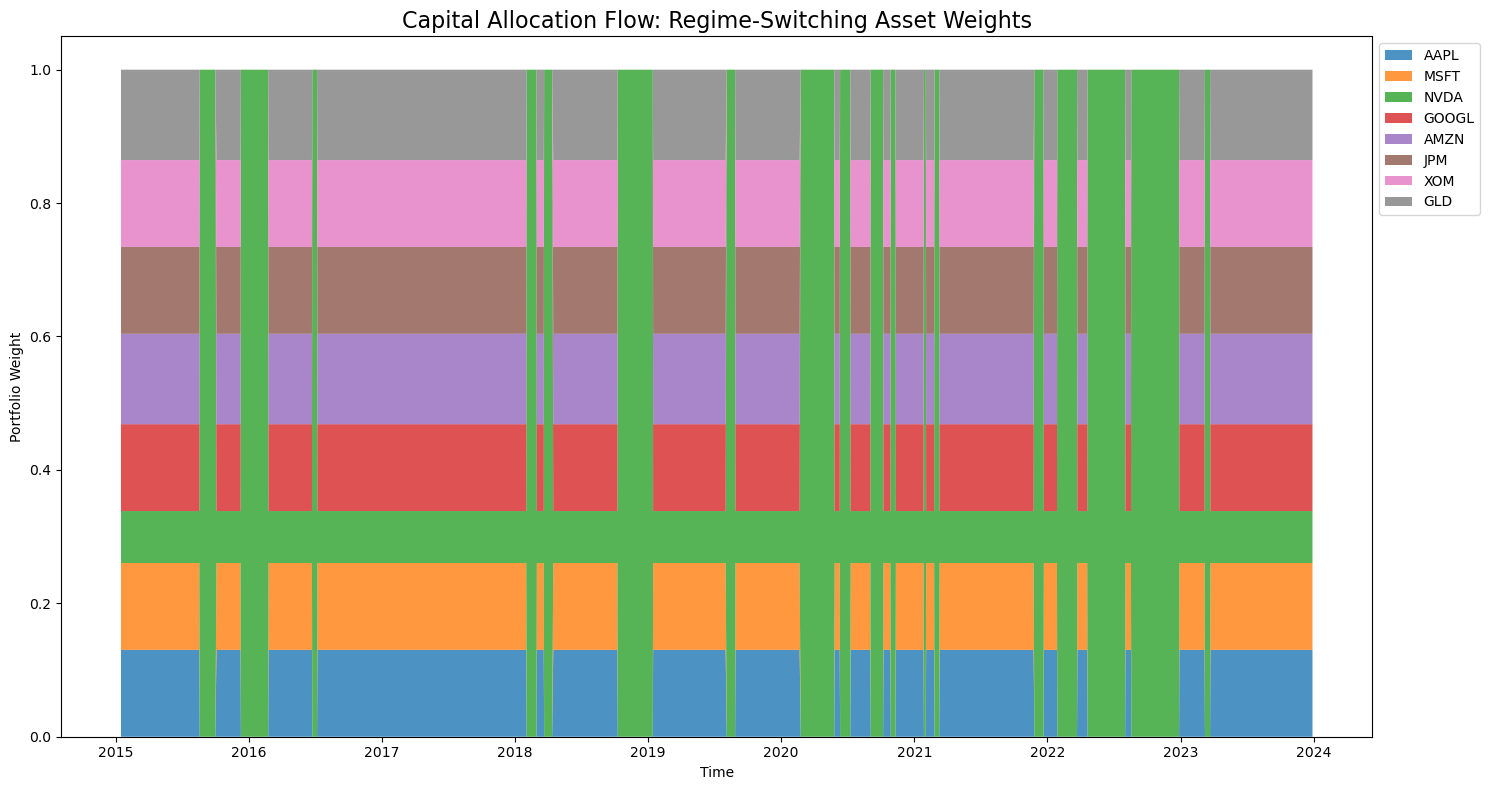

In [3]:
# Construct a timeline of weights based on the regime
dates = spy_df.index
tickers = config['data']['portfolio_tickers']

weight_history = []

for date in dates:
    regime = spy_df.loc[date, 'regime']
    if regime == 2: # Crash
        weight_history.append(weights_bear)
    else: # Bull or Sideways (default to Bull for simplicity)
        weight_history.append(weights_bull)

weight_df = pd.DataFrame(weight_history, index=dates, columns=tickers)

# Plot Stacked Area Chart
plt.figure(figsize=(15, 8))
plt.stackplot(weight_df.index, weight_df.T, labels=weight_df.columns, alpha=0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Capital Allocation Flow: Regime-Switching Asset Weights", fontsize=16)
plt.ylabel("Portfolio Weight")
plt.xlabel("Time")
plt.tight_layout()
plt.show()